## Parte 1 - Linear Regression

In [38]:
#notebook settings
%matplotlib inline

#import some useful libraries and utilities
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold

#setting some paths
path1='./cereales/'
path2='./credit/'

#parameters to try
params1 = np.array([0.2e-3, 0.4e-3, 0.6e-3, 0.8e-3, 1.0e-3])
params2 = np.linspace(4.0e-7,4.5e-7,5)

In [39]:
#Helper functions

"""
Function to generate histogram of winners (alphas)
"""
def make_hist(winners,parms):
    winners = np.array(winners)
    freqs = np.zeros(5)
    for i in xrange(5):
        freqs[i] = np.sum(parms[i]==winners)

    labels = ['alp1', 'alp2', 'alp3', 'alp4', 'alp5']
    pos = np.arange(len(labels))
    width = 1.0 
    ax = plt.axes()
    ax.set_xticks(pos + (width / 2))
    ax.set_xticklabels(labels)
    plt.bar(pos, freqs, width, color='r')
    plt.title('Best alpha for each dataset')
    plt.show()

def solve_all(algorithm, params=None, data_func=None):
    if params is not None:
        #list with winners-alphas
        winners = list()

    for i in xrange(20):
        #Loading dataset
        tr_file = path1+'cereales-tr-{0}.npy'.format(i)
        ts_file = path1+'cereales-ts-{0}.npy'.format(i)
        tr_data = np.load(tr_file)
        ts_data = np.load(ts_file)
        
        if data_func is not None:
            X_tr = data_func(tr_data[:,:-1])
        else: 
            X_tr = tr_data[:,:-1]
        y_tr = np.ascontiguousarray(tr_data[:,-1])
        #Adding column of 1's
        m,n = X_tr.shape
        X_tr = np.concatenate((np.ones((m,1)),X_tr),axis=1)

        if data_func is not None:
            X_ts = data_func(ts_data[:,:-1])
        else: 
            X_ts = ts_data[:,:-1]
        y_ts = np.ascontiguousarray(ts_data[:,-1])
        #Adding column of 1's
        m,n = X_ts.shape
        X_ts = np.concatenate((np.ones((m,1)),X_ts),axis=1)

        if params is not None:
            alpha,tr_cost,ts_cost = cross_alpha(X_tr, y_tr, algorithm, params)
            winners.append(alpha)
            beta,it = algorithm(X_tr, y_tr, alpha)
        else:
            beta,it = algorithm(X_tr, y_tr)
        print "###########################################################"
        print "Dataset: {0}".format(i)
        if params is not None:
            print 'Best alpha: {0}'.format(alpha)
            fig = plt.figure()
            fig.set_figheight(7)
            fig.set_figwidth(13)
            fig.add_subplot(121)
            plt.boxplot(tr_cost, showmeans=True, meanline=True)
            fig.add_subplot(122)
            plt.boxplot(ts_cost, showmeans=True, meanline=True)
            plt.show()
        print 'Training error: {0}'.format(mse(X_tr,y_tr,beta))
        print 'Testing error: {0}'.format(mse(X_ts,y_ts,beta))
        print 'N° iterations: {0}'.format(it)
        print 'Beta: {0}'.format(beta)
        print "###########################################################"
        print '\n'
    
    if params is not None:
        make_hist(winners,params)

In [40]:
#Overall cost function for linear regresion
def J(X, y, beta):
    h = np.dot(X,beta)
    diff = h-y
    return 0.5*np.dot(diff,diff)

#Mean Squared Error 
def mse(X, y, beta):
    M,N = X.shape
    h = np.dot(X,beta)
    diff = h-y
    return (1./(M-1))*np.dot(diff,diff)

#Batch gradient descent for linear regression
def gd_batch(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration
    for i in xrange(max_iter):
        J0 = J1
        h = np.dot(X,beta)
        dJ = np.dot(X.T,h-y)
        beta -= alpha*dJ
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps:
            break
    return (beta,i+1)

#Online gradient descent for linear regression
"""
Implmentation can be seen on gd.pyx. It was
made with Cython for seepdup
"""
#from gd import gd_online
def gd_online(X, y, alpha, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration
    for i in xrange(max_iter):
        J0 = J1
        for m in xrange(M):
            beta -= alpha*(np.dot(X[m],beta)-y[m])*X[m]
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps: break
    return (beta,i+1)

#Newton-Raphson method for linear regression
def nr_linear(X, y, eps=1e-5, max_iter=100000):
    M,N = X.shape
    beta = np.zeros(N)
    J1 = J(X,y,beta) #loss at previous iteration 
    Hess = np.dot(X.T,X) #Hessian matrix
    for i in xrange(max_iter):
        J0 = J1
        h = np.dot(X,beta)
        dJ = np.dot(X.T,h-y)
        beta -= np.linalg.solve(Hess, dJ)
        J1 = J(X,y,beta)
        if np.abs(J1-J0)/J0 < eps: break
    return (beta,i+1)

#Compute weights for all samples in X matrix, respect to x0
def weight(X, x0, tau):
    Diff = X - x0
    Diff *= Diff
    return np.exp(-1*np.sum(Diff,axis=1)/(2.*tau))

#Find best beta for locally weighted linear regression, with test x0
def min_weighted(X, y, x0, tau):
    #vector with weights
    W = np.diag(weight(X,x0,tau))
    M = np.dot(X.T, np.dot(W, X))
    b = np.dot(X.T, np.dot(W, y))
    return np.linalg.solve(M,b)

def rescale(M, a=0., b=1.):
    """ Rescale features of M to [a,b] range """
    #max and min vectors
    maxv = np.max(M, axis=0)
    minv = np.min(M, axis=0)
    return (b-a)*M/(maxv-minv) + (a*maxv-b*minv)/(maxv-minv)

def normalize(M):
    #mean and standard deviation vectors
    meanv = np.mean(M, axis=0)
    stdv = np.std(M, axis=0)
    return (M-meanv)/stdv

In [41]:
""" Find the best learning parameter for algorithm, between 
parameters in params using k-fold cross validation """
def cross_alpha(X, y, algorithm, params):
    #creating kfold
    m,n = X.shape
    kf = KFold(m, n_folds=5)
    tr_cost = np.empty((5,5))
    ts_cost = np.empty((5,5))
    i = 0 #index of fold
    
    for tr_index,ts_index in kf:
        j = 0 #index of parameter
        for param in params:
            X_train, X_test = X[tr_index], X[ts_index]
            y_train, y_test = y[tr_index], y[ts_index]
            beta,_ = algorithm(X_train, y_train, alpha=param)
            tr_cost[i,j] = mse(X_train, y_train, beta)
            ts_cost[i,j] = mse(X_test, y_test, beta)
            j += 1
        i += 1
        
    #arrays with mean costs for each alpha
    tr_mean = np.mean(tr_cost, axis=0) 
    ts_mean = np.mean(ts_cost, axis=0)
    return params[np.argmin(ts_mean)], tr_cost, ts_cost

def cross_tau():
    return

In [5]:
m,n = X.shape
x0 = np.random.random(n)
min_weighted(X,y,x0,0.5)

NameError: name 'X' is not defined

### Gradient descent batch for raw data

###########################################################
Dataset: 0
Best alpha: 4.5e-07


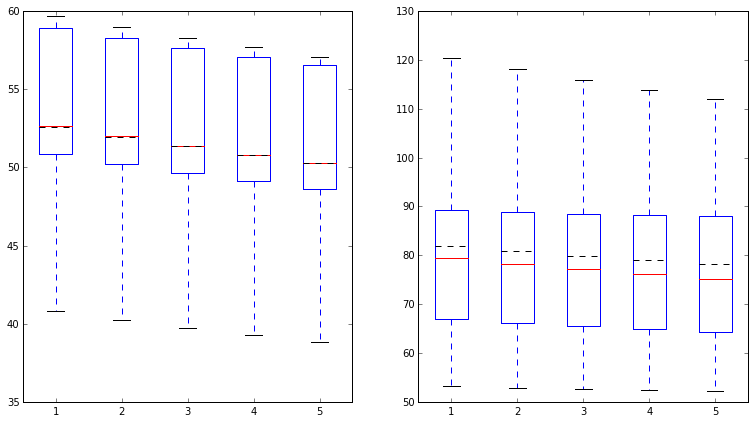

Training error: 47.7018651247
Testing error: 98.5365507026
N° iterations: 41839
Beta: [ 1.45007051 -0.07488509  3.6586664  -3.18223332 -0.06170004  3.49975134
  2.64216044  0.01071132 -0.01107893 -0.13169927  3.28244344  0.81753365
  1.61203648]
###########################################################


###########################################################
Dataset: 1
Best alpha: 4.5e-07


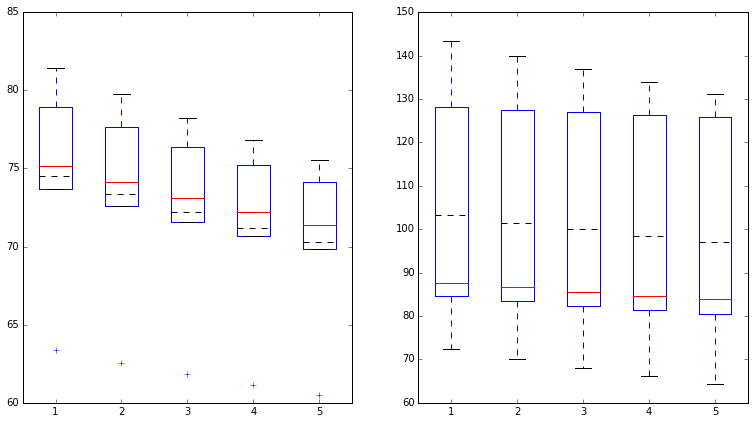

Training error: 64.7550597054
Testing error: 48.2315757796
N° iterations: 37395
Beta: [ 1.51151842 -0.13138068  3.85681757 -2.38975838 -0.0335923   2.53120612
  2.56108045  0.09368966  0.02998656 -0.12676098  2.72679839  0.78423382
  1.58448175]
###########################################################


###########################################################
Dataset: 2
Best alpha: 4.5e-07


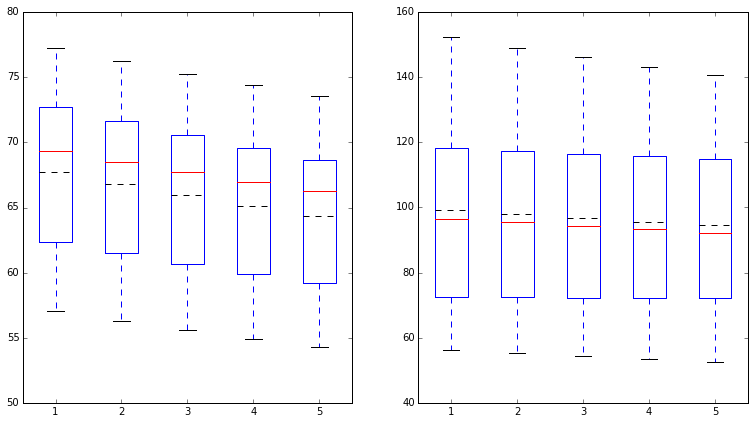

Training error: 60.7481463585
Testing error: 79.3615414274
N° iterations: 35558
Beta: [ 1.17969386 -0.13953799  3.78294308 -1.82756036 -0.03305847  2.50888648
  2.71785523  0.15927905  0.02106107 -0.13489473  2.33540385  0.68729504
  1.32478924]
###########################################################


###########################################################
Dataset: 3
Best alpha: 4.5e-07


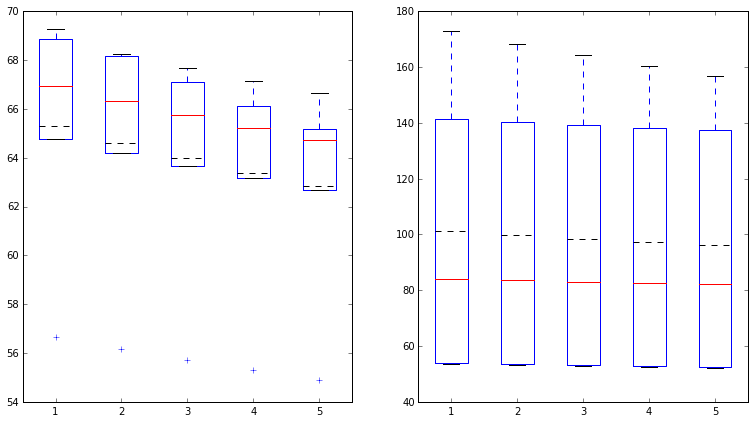

Training error: 58.9987667645
Testing error: 97.6149558458
N° iterations: 33429
Beta: [  1.25203426e+00   1.18167168e-03   3.01875186e+00  -2.88371921e+00
  -4.48843106e-02   3.51345829e+00   2.53504404e+00  -3.29583267e-01
  -5.33724219e-03  -1.66931668e-01   1.87341387e+00   5.78813824e-01
   1.45941431e+00]
###########################################################


###########################################################
Dataset: 4
Best alpha: 4.5e-07


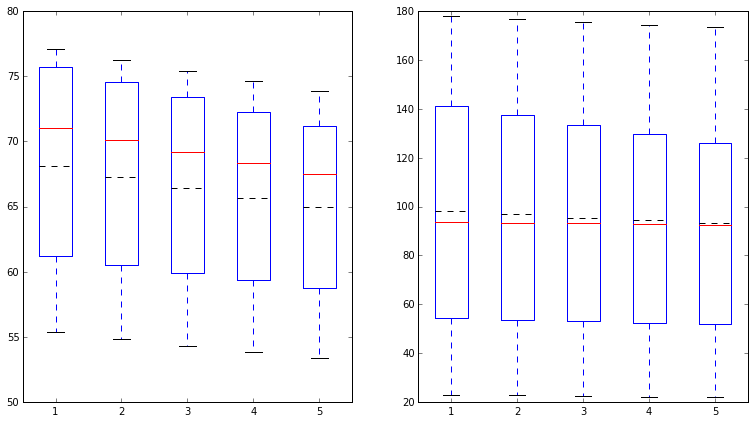

Training error: 60.3072912204
Testing error: 88.023192366
N° iterations: 33899
Beta: [ 1.24215199 -0.08193527  2.65716575 -2.15854073 -0.03925225  2.98855187
  2.71064704 -0.17171491  0.02214669 -0.15063159  2.70621456  0.82794457
  1.22588399]
###########################################################


###########################################################
Dataset: 5
Best alpha: 4.5e-07


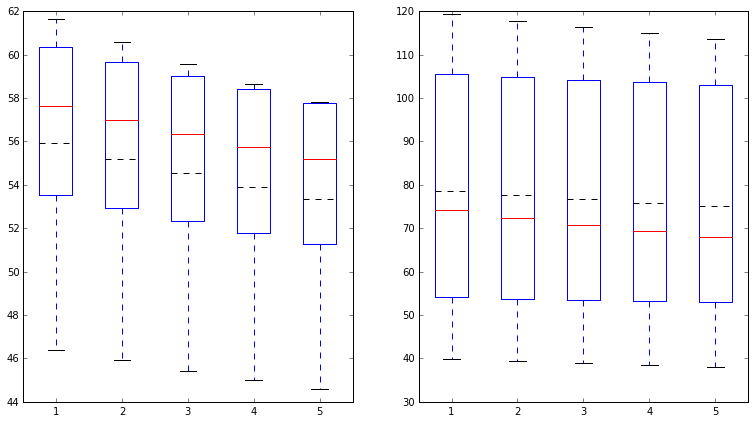

Training error: 50.8161360455
Testing error: 103.273046989
N° iterations: 37135
Beta: [ 1.20350502 -0.08930296  3.83324385 -2.45694911 -0.04535681  3.12053542
  2.55565498  0.00401994  0.02434499 -0.11672738  1.94519309  0.7931489
  1.26388671]
###########################################################


###########################################################
Dataset: 6
Best alpha: 4.5e-07


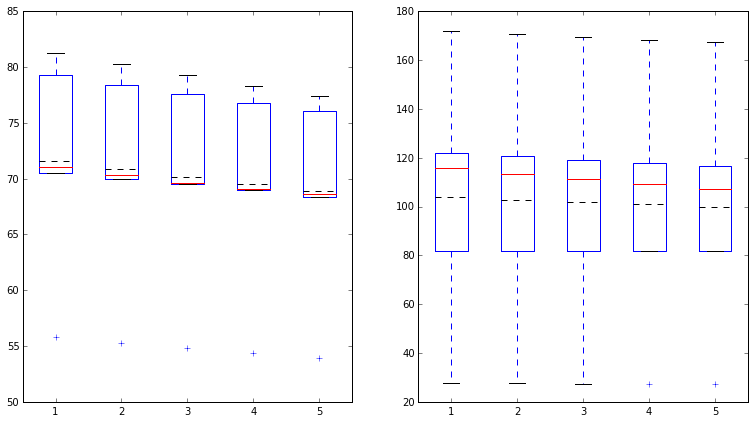

Training error: 65.6541052631
Testing error: 57.5892393027
N° iterations: 32693
Beta: [ 1.27903009 -0.03878925  3.40772812 -2.59294373 -0.02933009  3.04353951
  2.32056313 -0.29475475  0.01473876 -0.1526923   2.22168778  0.69725781
  1.34790144]
###########################################################


###########################################################
Dataset: 7
Best alpha: 4.5e-07


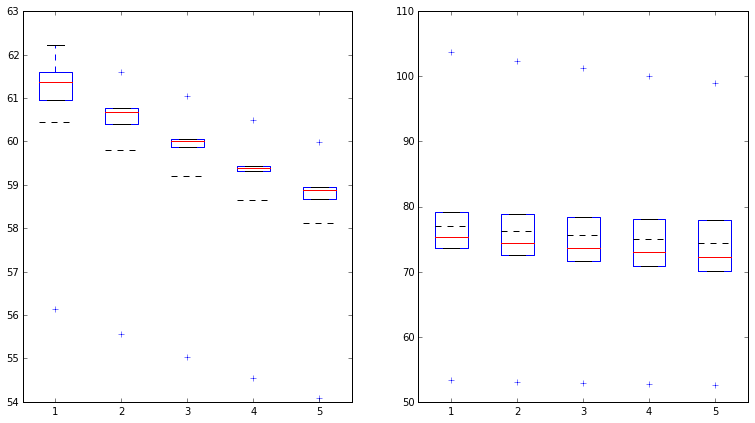

Training error: 55.4439862945
Testing error: 75.1149772436
N° iterations: 37075
Beta: [ 1.28365704 -0.08713122  3.98989369 -2.849145   -0.04344421  3.25455649
  2.5317626   0.11331768  0.01441116 -0.14838931  2.26488177  0.76079017
  1.49081129]
###########################################################


###########################################################
Dataset: 8
Best alpha: 4.5e-07


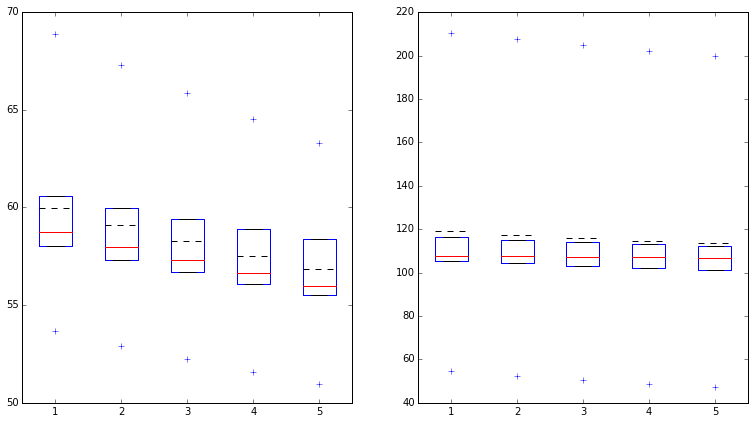

Training error: 54.5426469971
Testing error: 82.2107819498
N° iterations: 38927
Beta: [ 1.24561581 -0.07267351  3.2863172  -2.7469164  -0.05323766  3.01293599
  2.56609359  0.01704858  0.00336593 -0.12409025  3.19095961  0.80653327
  1.57989221]
###########################################################


###########################################################
Dataset: 9
Best alpha: 4.5e-07


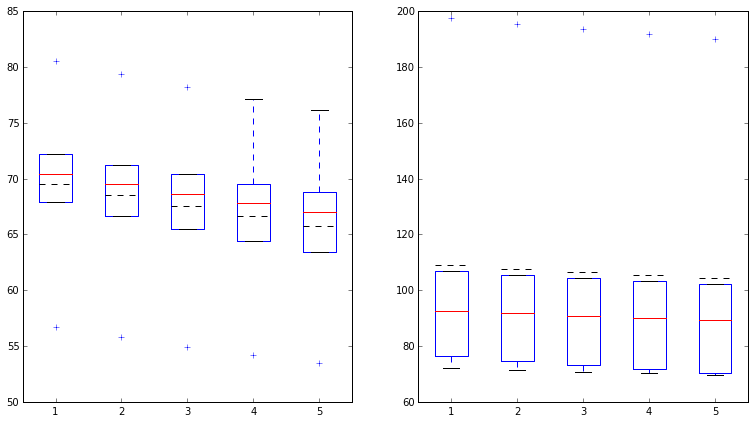

Training error: 62.4168368555
Testing error: 59.7595593067
N° iterations: 38408
Beta: [ 1.46658372 -0.10295414  4.0573884  -2.39316905 -0.03957536  2.27005469
  2.57954306  0.07813148  0.01603134 -0.14981853  2.72721511  0.84118777
  1.52602249]
###########################################################


###########################################################
Dataset: 10
Best alpha: 4.5e-07


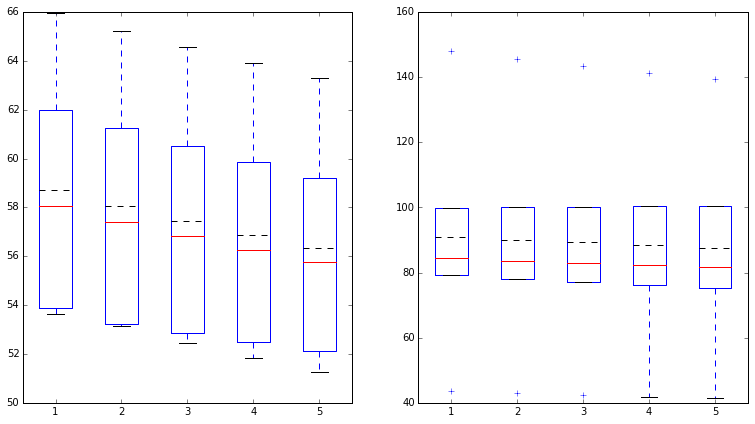

Training error: 54.2623055884
Testing error: 102.249628704
N° iterations: 35617
Beta: [ 1.16831853 -0.03918495  3.95638478 -2.63365326 -0.03014391  3.1621868
  2.18584239 -0.23403557  0.0088874  -0.08218795  1.50697396  0.74049203
  1.24216083]
###########################################################


###########################################################
Dataset: 11
Best alpha: 4.5e-07


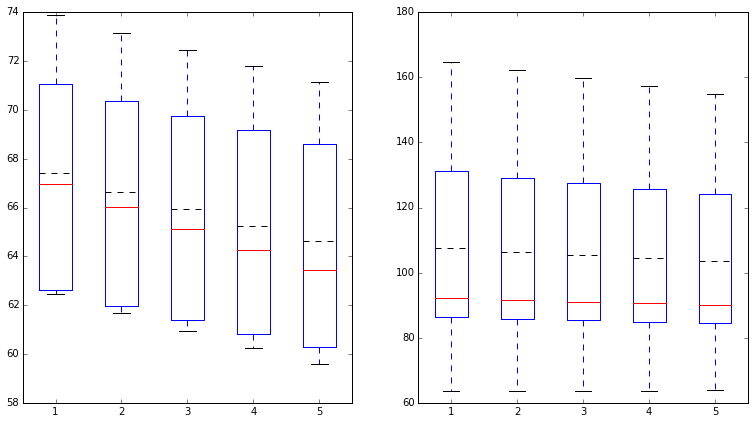

Training error: 62.0340545439
Testing error: 96.3581158257
N° iterations: 33306
Beta: [  1.10981655e+00  -5.10322177e-02   3.68956947e+00  -2.54729391e+00
  -4.67862581e-02   2.44906226e+00   2.47406756e+00   6.42013850e-02
   3.49242822e-03  -1.31328279e-01   1.88320918e+00   6.60243480e-01
   1.33877255e+00]
###########################################################


###########################################################
Dataset: 12
Best alpha: 4.5e-07


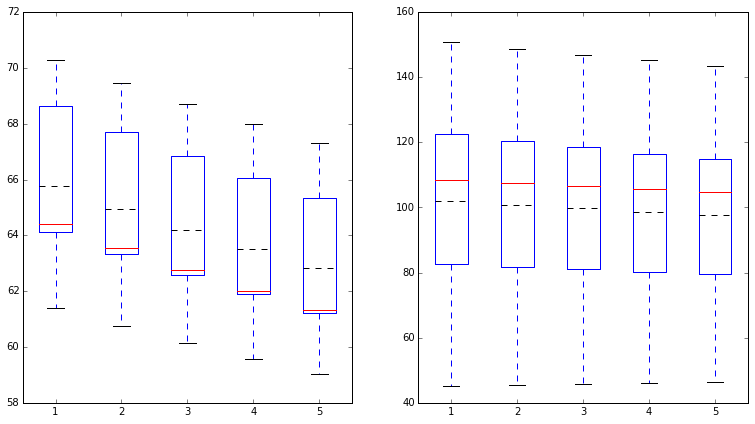

Training error: 60.1712404807
Testing error: 47.6982336899
N° iterations: 38458
Beta: [ 1.45433377 -0.08968786  4.24651413 -2.78368867 -0.03857028  2.92994807
  2.32117945  0.05748663  0.00854696 -0.10316297  2.88769513  0.78093322
  1.71517034]
###########################################################


###########################################################
Dataset: 13
Best alpha: 4.5e-07


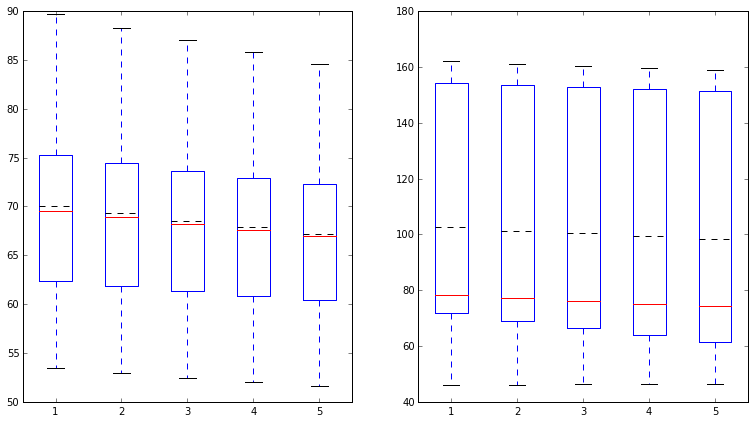

Training error: 63.8754224266
Testing error: 54.6855768246
N° iterations: 34544
Beta: [ 1.26294288 -0.06921313  3.7100431  -2.74170632 -0.04703039  2.85815788
  2.49956608 -0.02140664  0.01689035 -0.12755801  2.14607095  0.68777065
  1.60864618]
###########################################################


###########################################################
Dataset: 14
Best alpha: 4.5e-07


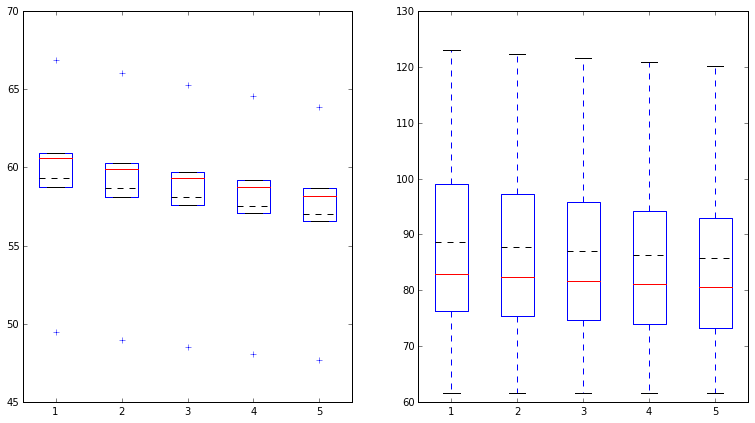

Training error: 55.3889121746
Testing error: 87.9559175097
N° iterations: 36435
Beta: [ 1.25097182 -0.06527964  4.28808828 -2.78390695 -0.03263313  2.25244654
  2.20500163  0.03132868  0.02280227 -0.0866293   2.26144347  0.67313098
  1.52788902]
###########################################################


###########################################################
Dataset: 15
Best alpha: 4.5e-07


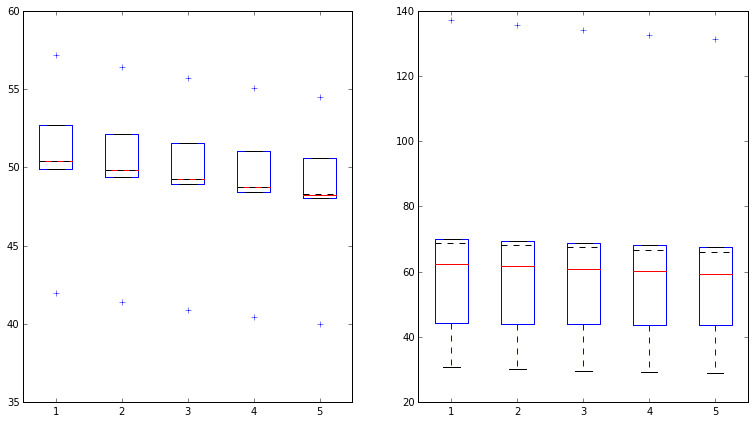

Training error: 46.1065815649
Testing error: 120.74160843
N° iterations: 41171
Beta: [ 1.43174894 -0.03773407  3.9914923  -2.78688194 -0.0362851   3.59588567
  2.08940944 -0.07587966 -0.00634996 -0.05640431  2.18350277  0.63561388
  1.13180144]
###########################################################


###########################################################
Dataset: 16
Best alpha: 4.5e-07


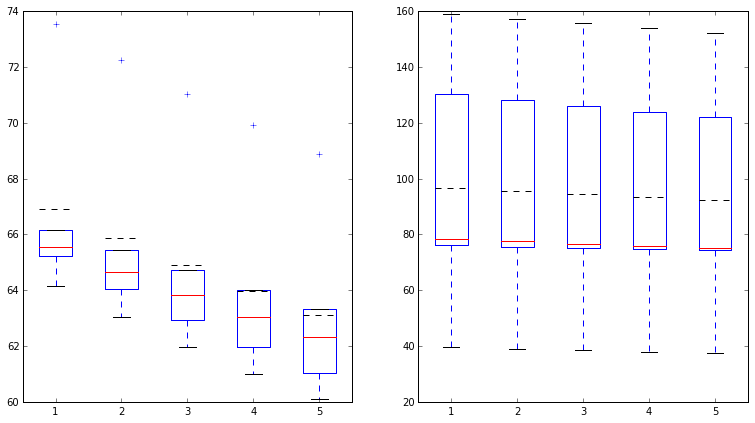

Training error: 58.7921426086
Testing error: 82.0169113703
N° iterations: 37313
Beta: [ 1.36353919 -0.14715022  3.46763084 -2.13118141 -0.0462796   2.57360503
  2.81836314  0.10845942  0.03626119 -0.10181231  2.47787117  0.62937244
  1.70474643]
###########################################################


###########################################################
Dataset: 17
Best alpha: 4.5e-07


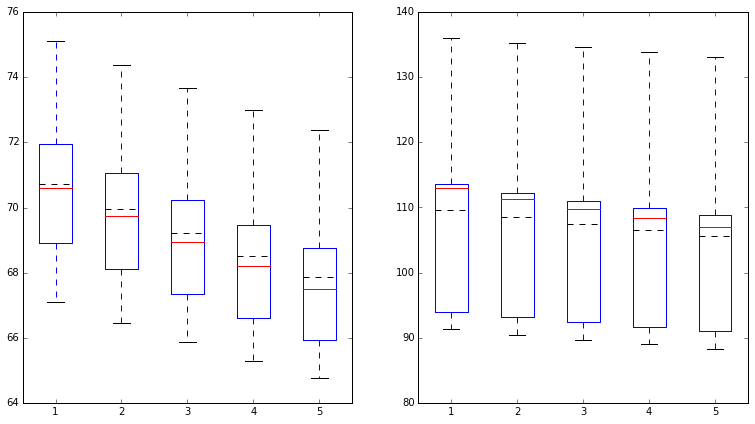

Training error: 65.6326333879
Testing error: 50.8059305089
N° iterations: 34370
Beta: [  1.43483394e+00   9.77333816e-03   3.23964259e+00  -3.05545702e+00
  -4.68517932e-02   3.28169124e+00   2.23782609e+00  -4.19906512e-01
   2.04841444e-03  -1.14762174e-01   2.38017662e+00   7.38252135e-01
   1.59065712e+00]
###########################################################


###########################################################
Dataset: 18
Best alpha: 4.5e-07


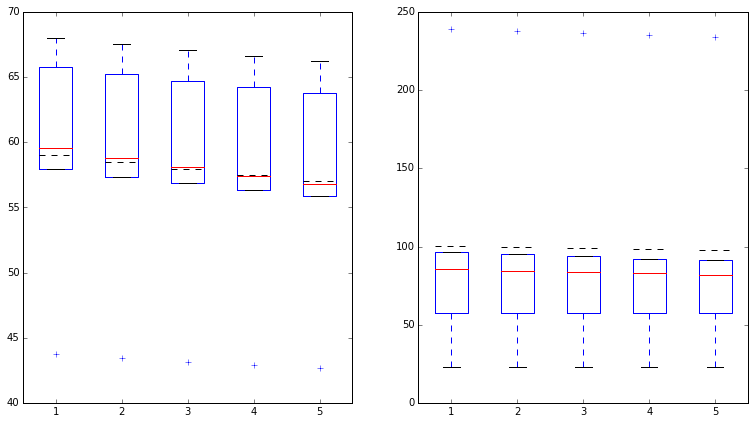

Training error: 56.5555399322
Testing error: 89.5246242367
N° iterations: 33340
Beta: [ 1.17370353 -0.07767876  3.53369067 -2.60439235 -0.03771718  3.58343137
  2.47778959  0.24231999 -0.00683109 -0.11976592  1.90929452  0.64435988
  1.29348523]
###########################################################


###########################################################
Dataset: 19
Best alpha: 4.5e-07


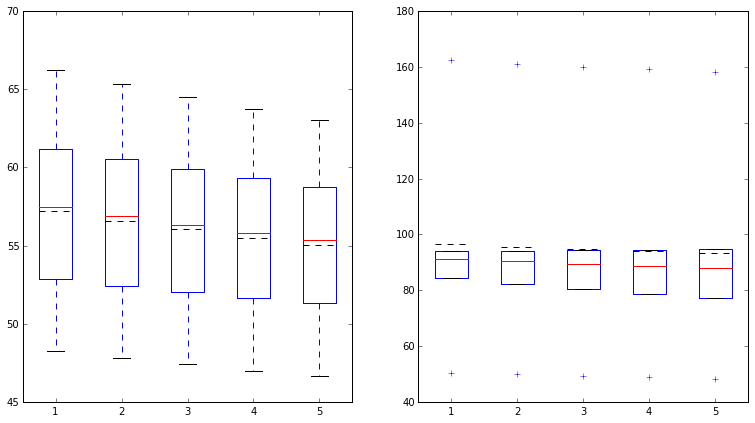

Training error: 53.8965499152
Testing error: 101.423157308
N° iterations: 36769
Beta: [ 1.27256142 -0.05788255  4.26424669 -2.18488152 -0.01905394  2.9310861
  2.01213426 -0.25756531  0.00593722 -0.10241576  2.55634214  0.77001516
  1.23669942]
###########################################################




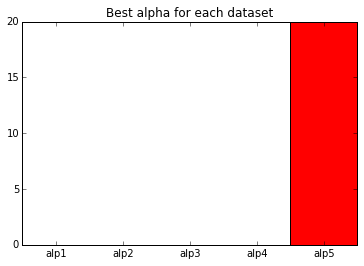

In [ ]:
solve_all(gd_batch, params=params2)

### Gradient descent batch for rescaled data [0,1]

###########################################################
Dataset: 0
Best alpha: 0.0006


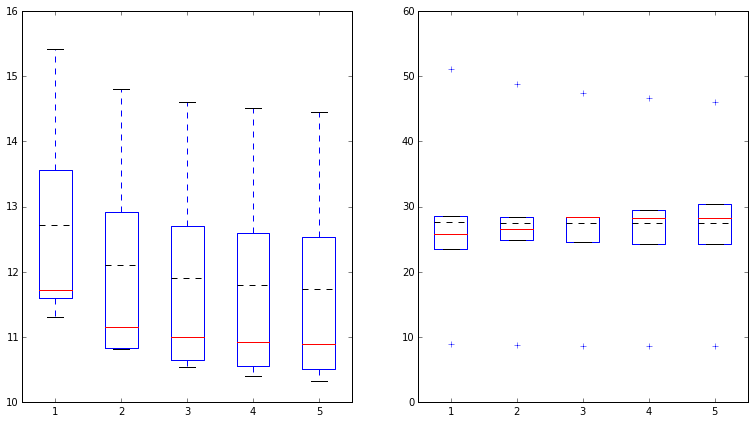

Training error: 13.0062050605
Testing error: 65.2571301369
N° iterations: 7718
Beta: [ 39.12819425 -21.12211183  18.39155828 -16.19472306 -15.69925885
  40.12054606  16.08049095 -16.64772494  -5.87286996 -13.08148087
   5.18930831   9.8497999   23.09701364]
###########################################################


###########################################################
Dataset: 1
Best alpha: 0.001


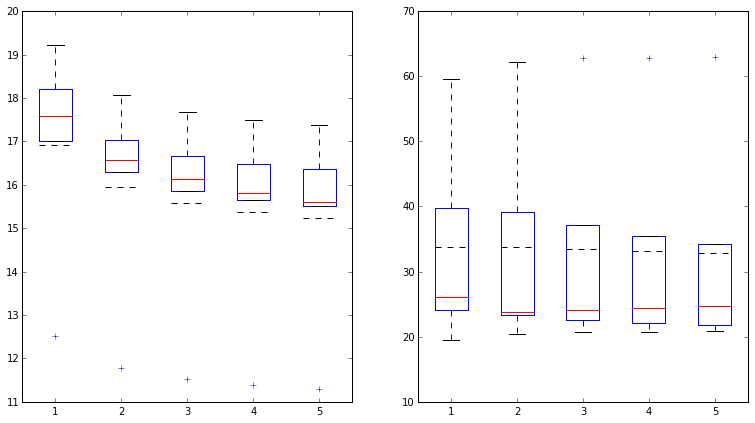

Training error: 16.3602257442
Testing error: 92.0230671423
N° iterations: 5765
Beta: [ 37.76010995 -23.91691135  19.33923593 -14.83153947 -11.34834923
  36.1198051   15.86964541 -12.49452803  -4.60486208 -10.83990299
   4.00286163   9.22876201  21.28151669]
###########################################################


###########################################################
Dataset: 2
Best alpha: 0.001


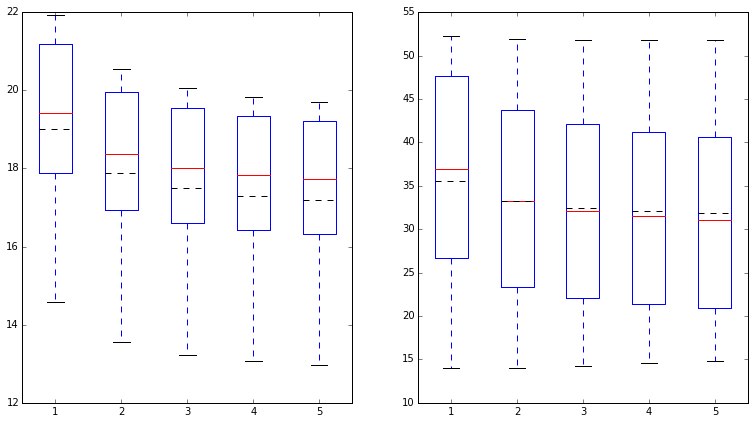

Training error: 18.1457842322
Testing error: 115.610985266
N° iterations: 5754
Beta: [ 40.97730612 -26.26603377  20.32655244 -15.10345033 -12.23326568
  40.2965877   15.18332197 -12.63207439  -9.01530236 -12.94318652
   6.49128172   8.50802687  20.73482906]
###########################################################


###########################################################
Dataset: 3
Best alpha: 0.001


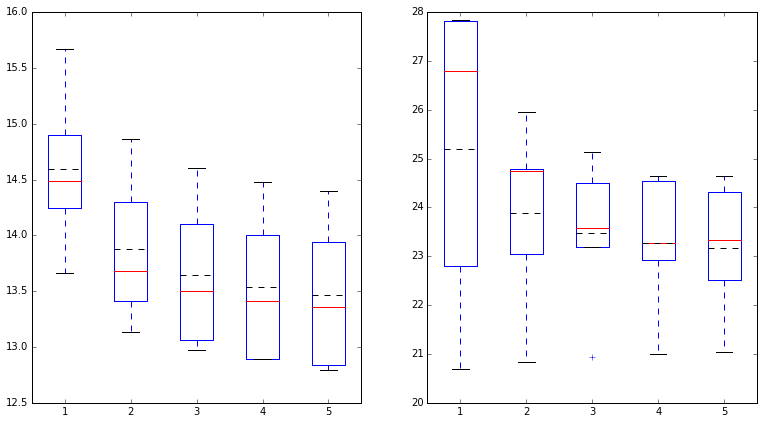

Training error: 14.1017329842
Testing error: 171.105766665
N° iterations: 5215
Beta: [ 43.47982853 -23.81054187  18.97143454 -14.94358074 -12.17779594
  40.78925657  14.30216321 -11.27322017  -6.88497476 -13.62507209
   4.77859147   5.18558864  17.3844609 ]
###########################################################


###########################################################
Dataset: 4
Best alpha: 0.001


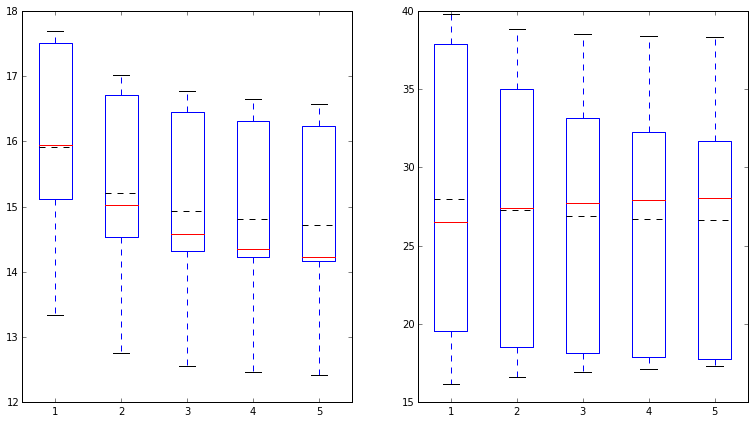

Training error: 15.5749130727
Testing error: 55.4477742699
N° iterations: 4782
Beta: [ 38.13862568 -22.8524058   19.41704046 -16.35695225 -14.1692096
  36.19605047  15.17684372 -14.74891235  -4.31813451 -13.3418267
   5.58138398  10.01687184  15.2289205 ]
###########################################################


###########################################################
Dataset: 5
Best alpha: 0.0002


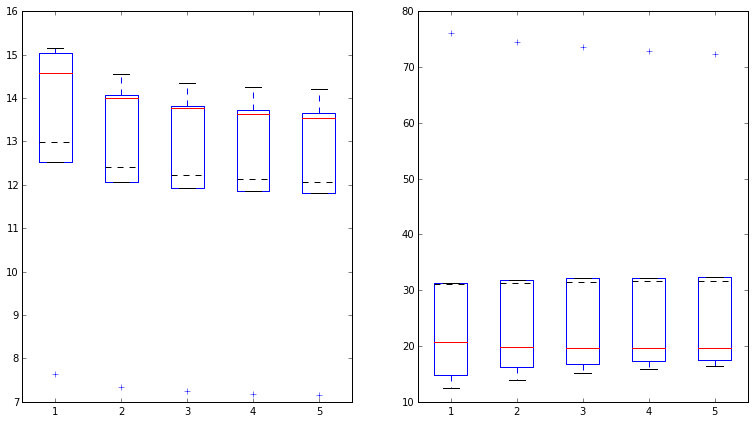

Training error: 14.2610314693
Testing error: 53.7595016258
N° iterations: 13100
Beta: [ 38.96905971 -22.3496242   18.61817791 -14.99228895 -16.47448789
  33.294526    18.74986081 -15.87213961   2.06616709 -11.27229725
   2.95665756   8.07107353  19.50895907]
###########################################################


###########################################################
Dataset: 6
Best alpha: 0.0002


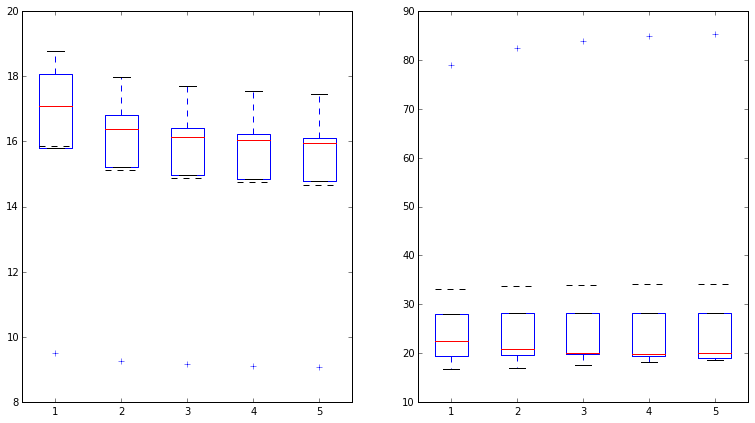

Training error: 17.0409159049
Testing error: 138.507544424
N° iterations: 11305
Beta: [ 41.70983088 -20.51953562  16.39039783 -14.08088911 -14.51329912
  29.63989364  15.73925204 -15.08751566   2.57449713 -13.14783703
   4.97107636   4.81431761  19.61171992]
###########################################################


###########################################################
Dataset: 7
Best alpha: 0.001


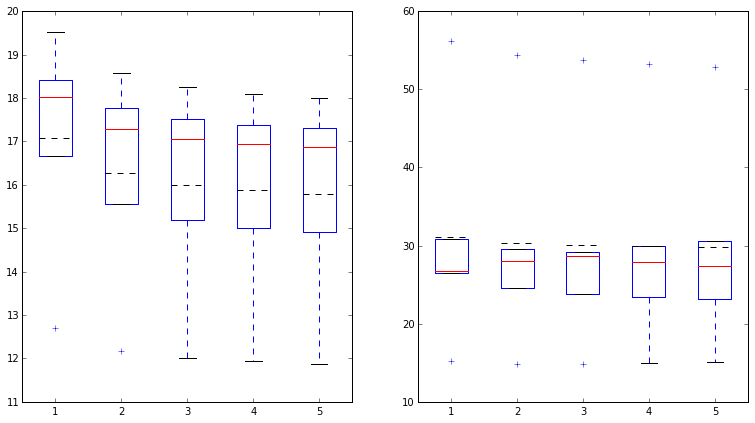

Training error: 16.7780811429
Testing error: 47.9171960704
N° iterations: 4865
Beta: [ 35.24725339 -23.12432222  19.24090643 -16.67993252 -15.71289131
  39.08325148  17.43375422 -14.25227046  -4.91821459 -13.17778673
   5.36529844  11.07718709  21.70014071]
###########################################################


###########################################################
Dataset: 8
Best alpha: 0.0004


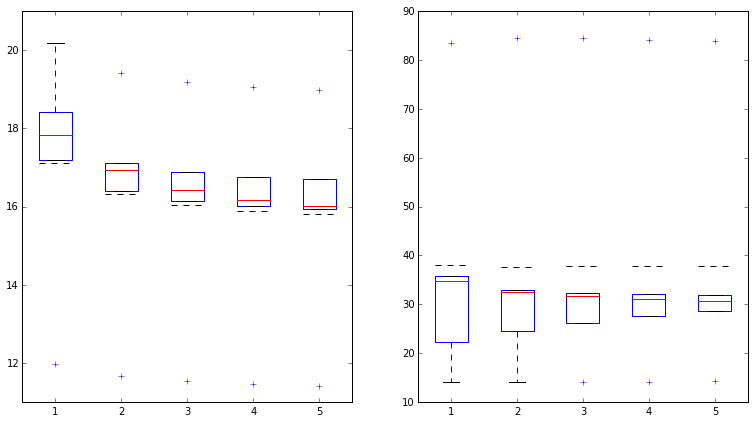

Training error: 17.6594834655
Testing error: 27.7334819973
N° iterations: 8714
Beta: [ 37.42648789 -21.9440614   17.92223893 -15.09850571 -13.9567529
  34.57936934  10.66467718 -17.44238188  -2.3707696  -12.39076294
   4.7661502   11.76878448  24.4317579 ]
###########################################################


###########################################################
Dataset: 9
Best alpha: 0.0006


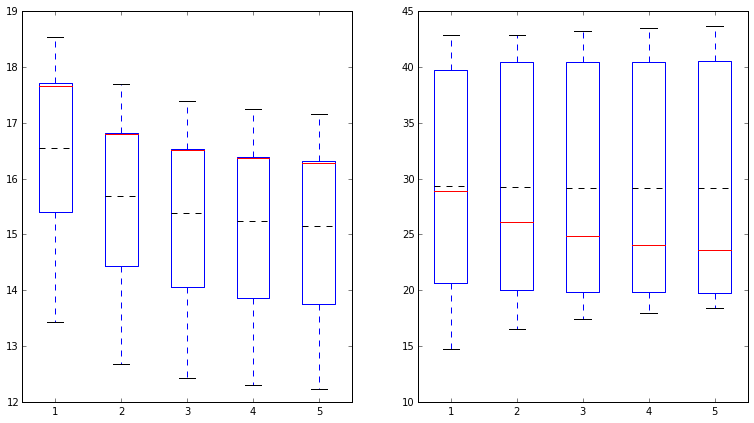

Training error: 16.3081104286
Testing error: 337.991435488
N° iterations: 7331
Beta: [ 36.07809829 -23.34706011  21.82703513 -16.90253197 -14.50602867
  30.50461255  15.59067892 -14.39360658 -10.69501581 -14.76462896
   5.72860295  12.19735217  20.68295466]
###########################################################


###########################################################
Dataset: 10
Best alpha: 0.001


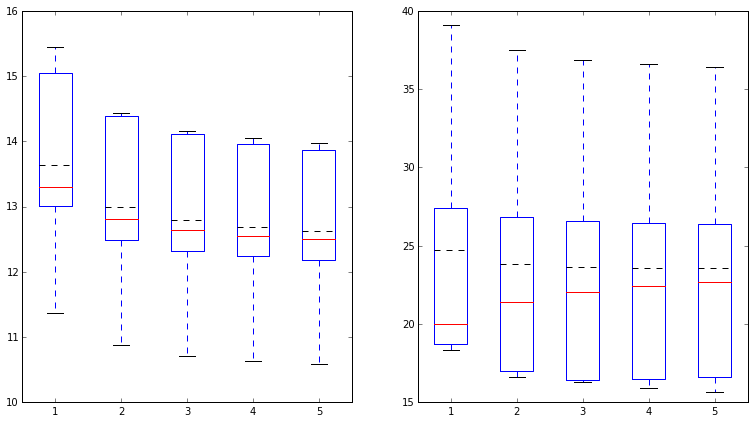

Training error: 13.4248859313
Testing error: 76.0132818686
N° iterations: 4895
Beta: [ 42.5434952  -21.13316114  21.98088829 -15.69155676 -15.44222201
  35.89580294  16.58903568 -13.43732599  -4.50854314 -10.56698216
   3.68367618   3.3306186   18.37652304]
###########################################################


###########################################################
Dataset: 11
Best alpha: 0.0002


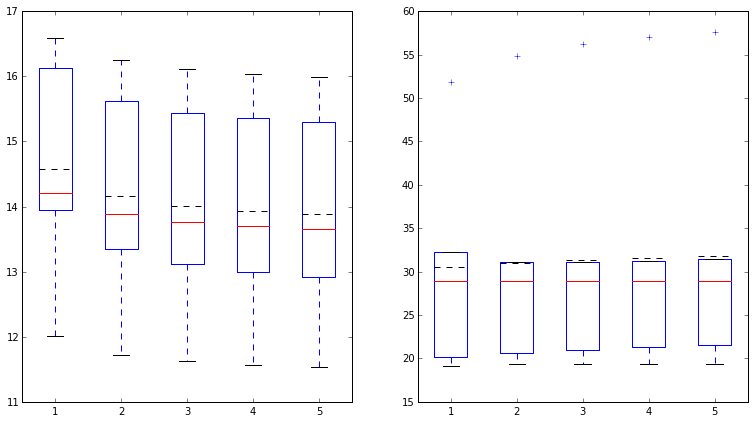

Training error: 15.8168112322
Testing error: 29.6423010367
N° iterations: 9607
Beta: [ 42.78315122 -21.42344317  18.90715836 -20.04294434 -13.2358552
  20.77143974  11.83444716 -15.35479563   0.08628419 -13.37862242
   4.28844871   9.81112513  19.07971477]
###########################################################


###########################################################
Dataset: 12
Best alpha: 0.0004


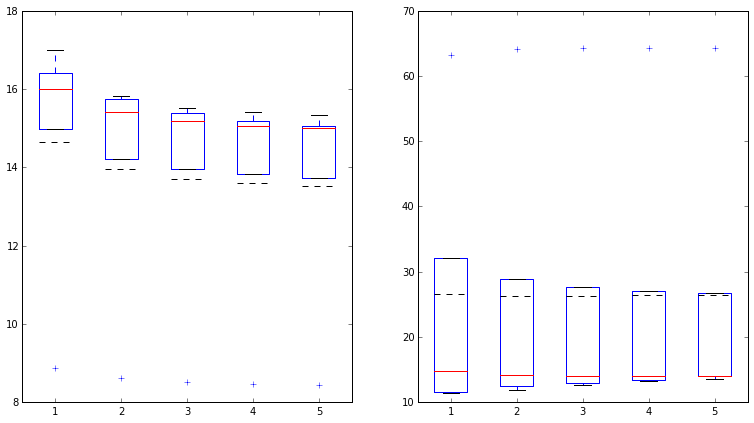

Training error: 14.7897334494
Testing error: 79.6061371602
N° iterations: 8756
Beta: [ 40.66170122 -23.03617014  17.83509579 -17.49820924 -14.65334601
  31.24612974  12.5497103  -17.15826607  -0.68050394  -8.31055737
   3.77579986  12.55725252  19.39283189]
###########################################################


###########################################################
Dataset: 13
Best alpha: 0.001


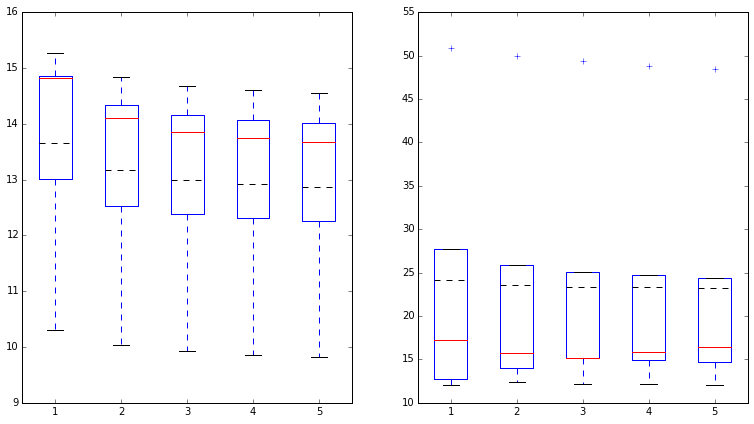

Training error: 13.5218597059
Testing error: 246.084167693
N° iterations: 4208
Beta: [ 39.03918344 -25.42444857  15.04479934 -14.00107694 -14.79234579
  28.6564351   13.8848172  -19.19484891  -5.21978877 -12.58570322
   5.25564017  13.45444692  25.19615693]
###########################################################


###########################################################
Dataset: 14
Best alpha: 0.0004


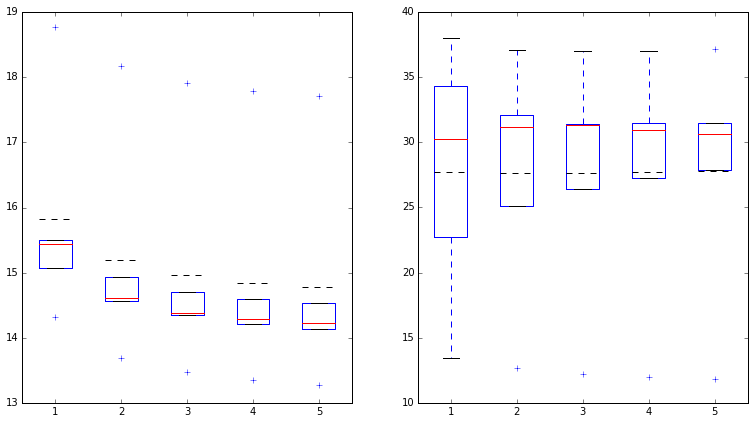

Training error: 16.0666898014
Testing error: 117.196223122
N° iterations: 7069
Beta: [ 34.73242323 -22.10504461  19.13642107 -17.57468323 -12.91483417
  24.70000691  16.79789533 -12.87150976  -0.28195429  -9.29053417
   4.82209831   7.73622924  21.85011054]
###########################################################


###########################################################
Dataset: 15
Best alpha: 0.001


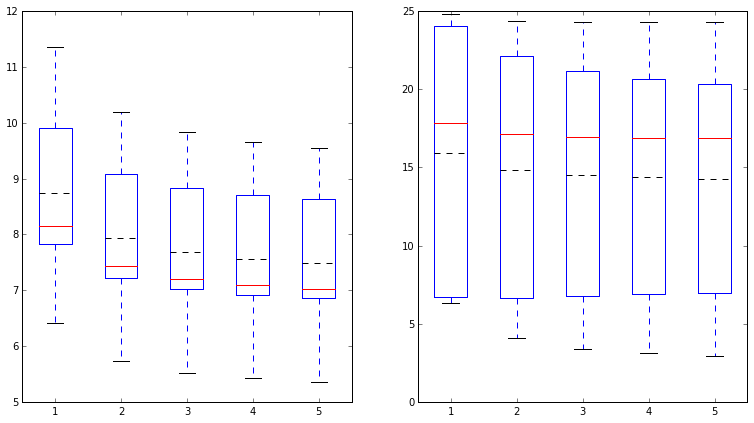

In [ ]:
solve_all(gd_batch, params=params1, data_func=rescale)

### Gradient descent batch for normalized data

In [ ]:
solve_all(gd_batch, params=params1, data_func=normalize)

### Gradient descent online for raw data

In [ ]:
solve_all(gd_online, params=params2)

### Gradient descent online for rescaled data [0,1]

In [ ]:
solve_all(gd_online, params=params1, data_func=rescale)

### Gradient descent online for normalized data

In [ ]:
solve_all(gd_online, params=params1, data_func=normalize)

### Newton-Raphson for raw data

In [45]:
solve_all(nr_linear)

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 29.8692128464
N° iterations: 2
Beta: [ 27.77312374  -0.19196441   3.64271996  -2.61978866  -0.04940511
   3.27558724   0.8950743   -0.94639251  -0.03448292  -0.13677948
   2.89862662  12.4397042   13.71043458]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 19.1213963039
N° iterations: 2
Beta: [ 32.77556027  -0.21889642   4.01031224  -2.79387988  -0.03884453
   3.10643719   0.67461777  -0.80667426  -0.03700155  -0.11417401
   2.23319673  12.31980684  12.62588456]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 13.1702299683
N° iterations: 2
Beta: [ 30.97809856  -0.22930608   4.12593951  -2.51735014  -0.04283795
   3.4

### Newton-Rhapson for rescaled data [0,1]

In [46]:
solve_all(nr_linear, data_func=rescale)

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 70.8230012379
N° iterations: 2
Beta: [ 37.68776506 -21.30804932  18.21359978 -15.71873198 -15.80963497
  45.85822131  16.11133741 -17.03506525 -10.86211949 -13.67794787
   5.79725325  12.4397042   24.27432442]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 105.300112485
N° iterations: 2
Beta: [ 36.81035813 -24.29750213  20.05156121 -13.96939941 -11.2649135
  43.49012072  14.84159095 -12.9067882  -11.98850316 -11.41740083
   4.46639345  12.31980684  22.35412861]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 139.177707921
N° iterations: 2
Beta: [ 39.98319337 -25.45297468  20.62969754 -15.10410084 -12.42300501
  47.71

### Newton-Raphson for normalized data

In [47]:
solve_all(nr_linear, data_func=normalize)

###########################################################
Dataset: 0
Training error: 12.690235978
Testing error: 39.1167896725
N° iterations: 2
Beta: [ 42.22724     -3.99216233   4.26196505  -3.44486437  -3.93375017
   8.28671753   3.23536861  -4.20056151  -2.37742955  -3.2700182
   2.44555845   1.89445678   3.72993749]
###########################################################


###########################################################
Dataset: 1
Training error: 15.9947888908
Testing error: 67.378076989
N° iterations: 2
Beta: [ 43.83778667  -4.60702487   4.40931759  -3.16661632  -3.13637015
   8.12721232   2.6937296   -3.56195787  -2.65364237  -2.37489256
   1.94115486   1.99611526   3.53901282]
###########################################################


###########################################################
Dataset: 2
Training error: 17.7637059001
Testing error: 18.9190672901
N° iterations: 2
Beta: [ 42.41314667  -4.37995712   4.69576307  -3.21485752  -3.29190982
   8.568